# Setup

In [64]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import sampler

to_float = torch.float
to_long = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)

cpu


# 加载数据集

In [121]:
train_data = datasets.ImageFolder('/home/dawn/文档/RecCifar10/cifar-10/train')
test_data = datasets.ImageFolder('/home/dawn/文档/RecCifar10/cifar-10/test')

# 随机提取6类

In [77]:
from PIL import Image

main_dir = os.getcwd()
train_dir = main_dir + "/extract_train"
test_dir = main_dir + "/extract_test"

#建立存放数据集的文件夹
if os.path.exists(train_dir) and os.path.exists(test_dir):
    pass
else:
    os.mkdir(train_dir)
    os.mkdir(test_dir)

#生成6个随机数，用于提取数据集中的6类
class_6 = torch.randperm(10)[:6]
print("Extract classes: ", class_6)

#提取6类并保存至新的文件夹
for i in range(50000):
    train_label = train_data.imgs[i][1]
    
    if train_label in class_6:
        train_label_dir = train_dir + "/" + str(train_label)
        if os.path.exists(train_label_dir):
            pass
        else:
            os.mkdir(train_label_dir)
        image_path = train_data.imgs[i][0]
        image = Image.open(image_path)
        save_path = train_label_dir + "/" + str(i) + ".jpg"
        image.save(save_path)

for i in range(10000):
    test_label = test_data.imgs[i][1]
        
    if test_label in class_6:
        test_label_dir = test_dir + "/" + str(test_label)
        if os.path.exists(test_label_dir):
            pass
        else:
            os.mkdir(test_label_dir)
        image_path = test_data.imgs[i][0]
        image = Image.open(image_path)
        save_path = test_label_dir + "/" + str(i) + ".jpg"
        image.save(save_path)

Extract classes:  tensor([5, 8, 3, 2, 0, 6])


In [126]:
import random

#定义预处理操作
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

#数据集预处理
train_data_ = datasets.ImageFolder(train_dir, transform=transform)
test_data_ = datasets.ImageFolder(test_dir, transform=transform)

#数据集采样、打包
n_train = len(train_data_)  #30000

split = 25000
indices = list(range(n_train))
random.shuffle(indices)

train_loader = torch.utils.data.DataLoader(train_data_, batch_size=64, 
                                          sampler=sampler.SubsetRandomSampler(indices[:split]))
valid_loader = torch.utils.data.DataLoader(train_data_, batch_size=64, 
                                        sampler=sampler.SubsetRandomSampler(indices[split:]))
test_loader = torch.utils.data.DataLoader(test_data_, batch_size=64, shuffle=True)

In [124]:
print(len(train_loader))

391


In [127]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            #3*32*32
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #16*16*16
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #32*8*8
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #64*4*4
            nn.Flatten(),
            nn.Linear(64*4*4, 500),
            nn.ReLU(),
            
            nn.Linear(500, 6),
        )
        
    def forward(self, x):
        return self.net(x)
model = Net()
print(model)
optimizer = optim.SGD(model.parameters(), lr=0.01)

Net(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=500, bias=True)
    (11): ReLU()
    (12): Linear(in_features=500, out_features=6, bias=True)
  )
)


In [123]:
def check_accuracy_part34(loader, model):
  #if loader.dataset.train:
  #  print('Checking accuracy on validation set')
  #else:
  #  print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=to_long).clamp(max=5)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

In [128]:
epochs = 5
num_prints = epochs * len(train_loader) // 100 + 1
acc_history = torch.zeros(num_prints, dtype=to_float)
iter_history = torch.zeros(num_prints, dtype=to_long)
model = model.to(device=device)# move the model parameters to CPU/GPU
for epoch in range(epochs):
    for t, (x, y) in enumerate(train_loader):
        model.train()
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=to_float)
        y = y.to(device=device, dtype=to_long).clamp(max=5)
        
        # Forward pass: compute scores and loss
        scores = model(x)
        loss = F.cross_entropy(scores, y)
        
        optimizer.zero_grad()
        
        #Backwards pass: compute the gradient
        loss.backward()
        
        #Update the parameters
        optimizer.step()
        
        tt = t + epoch * len(train_loader)
        
        if tt % 100 == 0 or (epoch == epochs - 1 and t == len(train_loader) - 1):
            print("Epoch: %d, Iteration: %d, loss = %.4f" %(epoch, tt, loss.item()))
            acc = check_accuracy_part34(valid_loader, model)
            acc_history[tt // 100] = acc
            iter_history[tt // 100] = tt
            print()

Epoch: 0, Iteration: 0, loss = 1.7947
Got 1038 / 5000 correct (20.76)

Epoch: 0, Iteration: 100, loss = 1.7849
Got 1552 / 5000 correct (31.04)

Epoch: 0, Iteration: 200, loss = 1.7631
Got 1748 / 5000 correct (34.96)

Epoch: 0, Iteration: 300, loss = 1.6858
Got 1672 / 5000 correct (33.44)

Epoch: 1, Iteration: 400, loss = 1.5984
Got 1816 / 5000 correct (36.32)

Epoch: 1, Iteration: 500, loss = 1.4981
Got 1890 / 5000 correct (37.80)

Epoch: 1, Iteration: 600, loss = 1.4738
Got 2005 / 5000 correct (40.10)

Epoch: 1, Iteration: 700, loss = 1.4865
Got 2096 / 5000 correct (41.92)

Epoch: 2, Iteration: 800, loss = 1.4133
Got 2086 / 5000 correct (41.72)

Epoch: 2, Iteration: 900, loss = 1.3869
Got 2181 / 5000 correct (43.62)

Epoch: 2, Iteration: 1000, loss = 1.3730
Got 2223 / 5000 correct (44.46)

Epoch: 2, Iteration: 1100, loss = 1.2620
Got 2307 / 5000 correct (46.14)

Epoch: 3, Iteration: 1200, loss = 1.3099
Got 2273 / 5000 correct (45.46)

Epoch: 3, Iteration: 1300, loss = 1.3925
Got 2347 

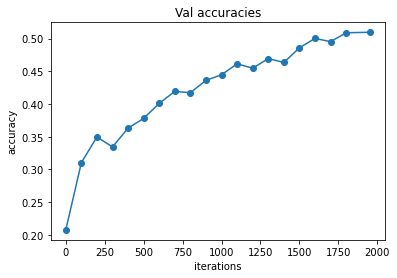

In [129]:
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()